In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import grad

In [80]:
def L(x, y, dy_dx):
    """
    Example Lagrangian: L = 0.5 * (dy/dx)^2 - 0.5 * y^2
    """
    return 0.5 * dy_dx**2 - 0.5 * y**2 + 0 * x


In [81]:
x_range = (0.0, 10)  # Range for x
initial_conditions = [
    {'type': 'y', 'value': 1.0, 'x': 0.0},    # y(0) = 1
    {'type': 'y\'', 'value': 0.0, 'x': 0.0},  # y'(0) = 0
    #{'type': 'y', 'value': 0.0, 'x': 2 * np.pi},  # y(2*pi) = 0
    # Additional initial conditions can be added if needed
    # {'type': 'y', 'value': ..., 'x': ...},
    # {'type': 'y\'', 'value': ..., 'x': ...}
]

In [82]:
def compute_euler_lagrange(L, x, y, dy_dx):
    """
    Compute the residual of the Euler-Lagrange equation:
    dL/dy - d/dx(dL/d(dy/dx)).
    """
    # Ensure tensors require gradients for autograd
    x.requires_grad_(True)
    y.requires_grad_(True)
    dy_dx.requires_grad_(True)

    # Compute Lagrangian
    L_value = L(x, y, dy_dx)
    
    # Compute partial derivative ∂L/∂y
    dL_dy = torch.autograd.grad(L_value, y, grad_outputs=torch.ones_like(L_value), create_graph=True)[0]

    # Compute partial derivative ∂L/∂(dy/dx)
    dL_dy_dx = torch.autograd.grad(L_value, dy_dx, grad_outputs=torch.ones_like(L_value), create_graph=True)[0]

    # Compute total derivative d/dx(∂L/∂(dy/dx))
    if dL_dy_dx.requires_grad:
        d_dL_dy_dx = torch.autograd.grad(dL_dy_dx, x, grad_outputs=torch.ones_like(dL_dy_dx), create_graph=True)[0]
    else:
        d_dL_dy_dx = torch.zeros_like(x)

    # Compute Euler-Lagrange residual
    residual = dL_dy - d_dL_dy_dx

    return residual

In [83]:
# Define neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(1, 200)
        self.hidden_layer_2 = nn.Linear(200, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.sin(self.hidden_layer_1(x))
        x = torch.sin(self.hidden_layer_2(x))
        x = torch.sin(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x


In [84]:
def f_ode(x, net):
    y = net(x)  # Neural network approximation of y(x)
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(x), create_graph=True)[0]  # dy/dx
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(x), create_graph=True)[0]  # d2y/dx2

    # Use Lagrangian to compute the Euler-Lagrange residual
    ode_residual = compute_euler_lagrange(L, x, y, dy_dx)

    return ode_residual

In [85]:
def apply_initial_conditions(net, initial_conditions):
    ivp_residuals = []
    
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)  # Boundary point at x = ivp['x']
        y_ivp = net(x_ivp)  # Predict y(x_ivp)

        if ivp['type'] == 'y':  # Apply condition for y(x)
            ivp_residual = y_ivp - ivp['value']  # y(x) = given value
        elif ivp['type'] == 'y\'':  # Apply condition for y'(x)
            dy_dx_ivp = torch.autograd.grad(y_ivp, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]  # y'(x)
            ivp_residual = dy_dx_ivp - ivp['value']  # y'(x) = given value
        
        ivp_residuals.append(ivp_residual)
    
    return torch.sum(torch.stack([ivp**2 for ivp in ivp_residuals]))  # Sum of residuals squared

In [86]:
def train(net, optimizer, x_range, initial_conditions, num_epochs):
    x_min, x_max = x_range
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Reset gradients

        # Sample points in the domain x
        x = torch.linspace(x_min, x_max, 100).view(-1, 1)
        x.requires_grad = True  # Enable gradient tracking for these inputs

        # Compute the ODE residual
        ode_residual = f_ode(x, net)

        # Compute the initial value condition residuals
        ivp_residual = apply_initial_conditions(net, initial_conditions)

        # Define the loss as the sum of the ODE residuals and initial condition residuals
        loss = torch.mean(ode_residual**2) + ivp_residual

        # Perform backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [87]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train(net, optimizer, x_range, initial_conditions, num_epochs=1000)

Epoch 0, Loss: 1.0656583309173584
Epoch 10, Loss: 0.06226801499724388
Epoch 20, Loss: 0.052985791116952896
Epoch 30, Loss: 0.018604179844260216
Epoch 40, Loss: 0.012913026846945286
Epoch 50, Loss: 0.005584376398473978
Epoch 60, Loss: 0.0027294112369418144
Epoch 70, Loss: 0.0009760420070961118
Epoch 80, Loss: 0.0002857876243069768
Epoch 90, Loss: 0.00012130429240642115
Epoch 100, Loss: 9.221513755619526e-05
Epoch 110, Loss: 5.9150428569409996e-05
Epoch 120, Loss: 4.74712869618088e-05
Epoch 130, Loss: 4.370358510641381e-05
Epoch 140, Loss: 3.892230961355381e-05
Epoch 150, Loss: 3.528323577484116e-05
Epoch 160, Loss: 3.242334787501022e-05
Epoch 170, Loss: 2.988762025779579e-05
Epoch 180, Loss: 2.760234201559797e-05
Epoch 190, Loss: 2.555297214712482e-05
Epoch 200, Loss: 2.3708400476607494e-05
Epoch 210, Loss: 2.2043090211809613e-05
Epoch 220, Loss: 2.0539393517537974e-05
Epoch 230, Loss: 1.918181988003198e-05
Epoch 240, Loss: 1.7956073861569166e-05
Epoch 250, Loss: 1.684911512711551e-05
E

In [88]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    
    y_pred = net(x_tensor).detach().numpy()
    
    # Plotting the predicted solution
    plt.plot(x_values, y_pred, label="NN Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the ODE learned by the Neural Network")
    plt.legend()
    plt.grid(True)
    plt.show()

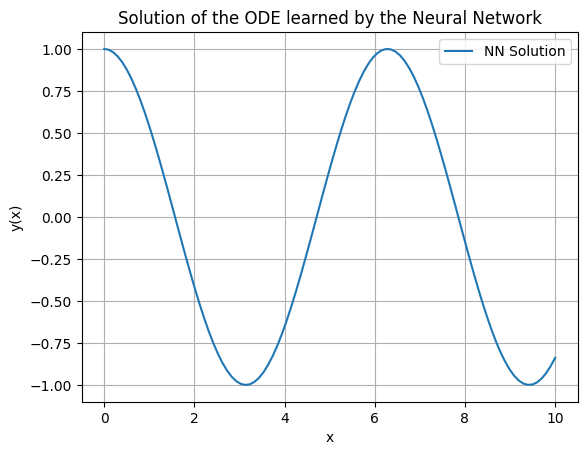

In [89]:
visualize_solution(net, x_range)